In [0]:
# Import required libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession

df = spark.read.format("delta").load("dbfs:/user/hive/warehouse/air_passengers")

# Show the first few rows of the dataset
df.show()

+----------+-----------+
|     Month|#Passengers|
+----------+-----------+
|1949-01-01|        112|
|1949-02-01|        118|
|1949-03-01|        132|
|1949-04-01|        129|
|1949-05-01|        121|
|1949-06-01|        135|
|1949-07-01|        148|
|1949-08-01|        148|
|1949-09-01|        136|
|1949-10-01|        119|
|1949-11-01|        104|
|1949-12-01|        118|
|1950-01-01|        115|
|1950-02-01|        126|
|1950-03-01|        141|
|1950-04-01|        135|
|1950-05-01|        125|
|1950-06-01|        149|
|1950-07-01|        170|
|1950-08-01|        170|
+----------+-----------+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import to_date

# Convert 'Month' to a DateType column
df = df.withColumn("Date", to_date(df['Month'], 'MMM-yyyy'))

# Show the updated DataFrame with Date column
df.show()

+----------+-----------+----------+
|     Month|#Passengers|      Date|
+----------+-----------+----------+
|1949-01-01|        112|1949-01-01|
|1949-02-01|        118|1949-02-01|
|1949-03-01|        132|1949-03-01|
|1949-04-01|        129|1949-04-01|
|1949-05-01|        121|1949-05-01|
|1949-06-01|        135|1949-06-01|
|1949-07-01|        148|1949-07-01|
|1949-08-01|        148|1949-08-01|
|1949-09-01|        136|1949-09-01|
|1949-10-01|        119|1949-10-01|
|1949-11-01|        104|1949-11-01|
|1949-12-01|        118|1949-12-01|
|1950-01-01|        115|1950-01-01|
|1950-02-01|        126|1950-02-01|
|1950-03-01|        141|1950-03-01|
|1950-04-01|        135|1950-04-01|
|1950-05-01|        125|1950-05-01|
|1950-06-01|        149|1950-06-01|
|1950-07-01|        170|1950-07-01|
|1950-08-01|        170|1950-08-01|
+----------+-----------+----------+
only showing top 20 rows



In [0]:
# Create a temporary view for SQL queries
df.createOrReplaceTempView("airline_data")

In [0]:
# Trend Analysis Using Moving Average
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Define window for moving average calculation (6 months rolling window)
windowSpec = Window.orderBy("Date").rowsBetween(-6, 0)

# Calculate 6-month moving average
df_with_trend = df.withColumn("Moving_Avg", F.avg("#Passengers").over(windowSpec))
df_with_trend.show()

+----------+-----------+----------+------------------+
|     Month|#Passengers|      Date|        Moving_Avg|
+----------+-----------+----------+------------------+
|1949-01-01|        112|1949-01-01|             112.0|
|1949-02-01|        118|1949-02-01|             115.0|
|1949-03-01|        132|1949-03-01|120.66666666666667|
|1949-04-01|        129|1949-04-01|            122.75|
|1949-05-01|        121|1949-05-01|             122.4|
|1949-06-01|        135|1949-06-01|             124.5|
|1949-07-01|        148|1949-07-01|127.85714285714286|
|1949-08-01|        148|1949-08-01|             133.0|
|1949-09-01|        136|1949-09-01|135.57142857142858|
|1949-10-01|        119|1949-10-01|133.71428571428572|
|1949-11-01|        104|1949-11-01|130.14285714285714|
|1949-12-01|        118|1949-12-01|129.71428571428572|
|1950-01-01|        115|1950-01-01|126.85714285714286|
|1950-02-01|        126|1950-02-01|123.71428571428571|
|1950-03-01|        141|1950-03-01|122.71428571428571|
|1950-04-0

In [0]:
# Seasonality Detection
# Extract year and month from the Date column
df_with_seasonality = df.withColumn("Year", F.year("Date")).withColumn("Month", F.month("Date"))

# Calculate the average number of passengers for each month
seasonality = df_with_seasonality.groupBy("Month").agg(F.avg("#Passengers").alias("Avg_Passengers"))
seasonality.show()

+-----+------------------+
|Month|    Avg_Passengers|
+-----+------------------+
|   12| 261.8333333333333|
|    1|            241.75|
|    6| 311.6666666666667|
|    3| 270.1666666666667|
|    5| 271.8333333333333|
|    9| 302.4166666666667|
|    4| 267.0833333333333|
|    8| 351.0833333333333|
|    7| 351.3333333333333|
|   10| 266.5833333333333|
|   11|232.83333333333334|
|    2|             235.0|
+-----+------------------+



In [0]:
# Anomaly Detection Using Z-Score
# Calculate the mean and standard deviation of passengers
mean_passengers = df.agg(F.mean("#Passengers")).collect()[0][0]
stddev_passengers = df.agg(F.stddev("#Passengers")).collect()[0][0]

# Calculate Z-score for anomaly detection
df_with_anomalies = df.withColumn("Z_Score", (df["#Passengers"] - mean_passengers) / stddev_passengers)

# Identify anomalies where Z-score is greater than a threshold (e.g., 3)
anomalies = df_with_anomalies.filter(F.abs(df_with_anomalies["Z_Score"]) > 3)
anomalies.show()

+-----+-----------+----+-------+
|Month|#Passengers|Date|Z_Score|
+-----+-----------+----+-------+
+-----+-----------+----+-------+



In [0]:
# Show the DataFrame with Z-Scores to inspect the range of values
df_with_anomalies.show()


+----------+-----------+----------+-------------------+
|     Month|#Passengers|      Date|            Z_Score|
+----------+-----------+----------+-------------------+
|1949-01-01|        112|1949-01-01|-1.4028822039369186|
|1949-02-01|        118|1949-02-01|-1.3528681653893015|
|1949-03-01|        132|1949-03-01|-1.2361687421115286|
|1949-04-01|        129|1949-04-01|-1.2611757613853372|
|1949-05-01|        121|1949-05-01| -1.327861146115493|
|1949-06-01|        135|1949-06-01|  -1.21116172283772|
|1949-07-01|        148|1949-07-01|-1.1027979726512167|
|1949-08-01|        148|1949-08-01|-1.1027979726512167|
|1949-09-01|        136|1949-09-01|-1.2028260497464507|
|1949-10-01|        119|1949-10-01|-1.3445324922980322|
|1949-11-01|        104|1949-11-01|-1.4695675886670745|
|1949-12-01|        118|1949-12-01|-1.3528681653893015|
|1950-01-01|        115|1950-01-01|  -1.37787518466311|
|1950-02-01|        126|1950-02-01|-1.2861827806591457|
|1950-03-01|        141|1950-03-01|-1.1611476842

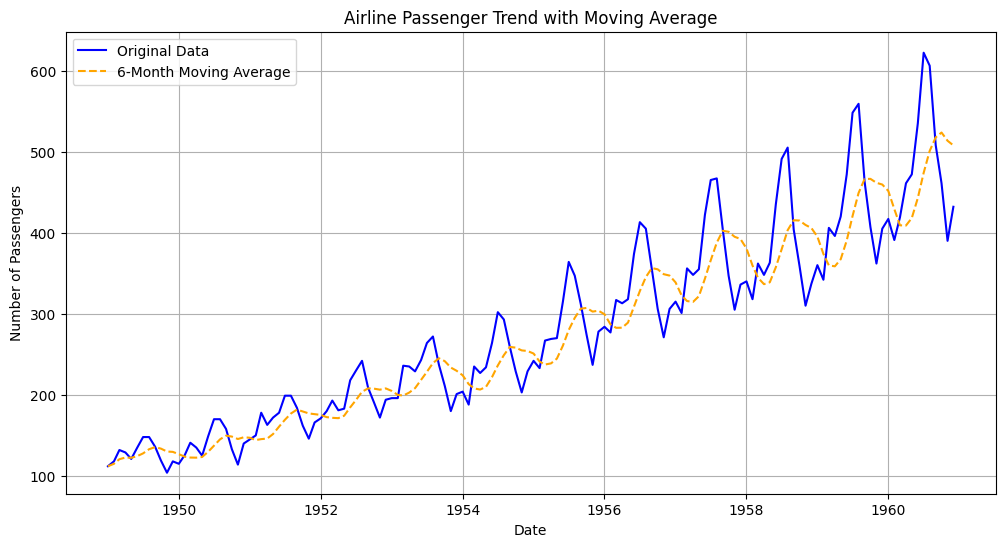

In [0]:
# Visualizing Trend using Moving Average
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas for easy plotting in Databricks
df_trend = df_with_trend.toPandas()

# Plotting the trend
plt.figure(figsize=(12, 6))
plt.plot(df_trend['Date'], df_trend['#Passengers'], label='Original Data', color='blue')
plt.plot(df_trend['Date'], df_trend['Moving_Avg'], label='6-Month Moving Average', color='orange', linestyle='--')
plt.title('Airline Passenger Trend with Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()


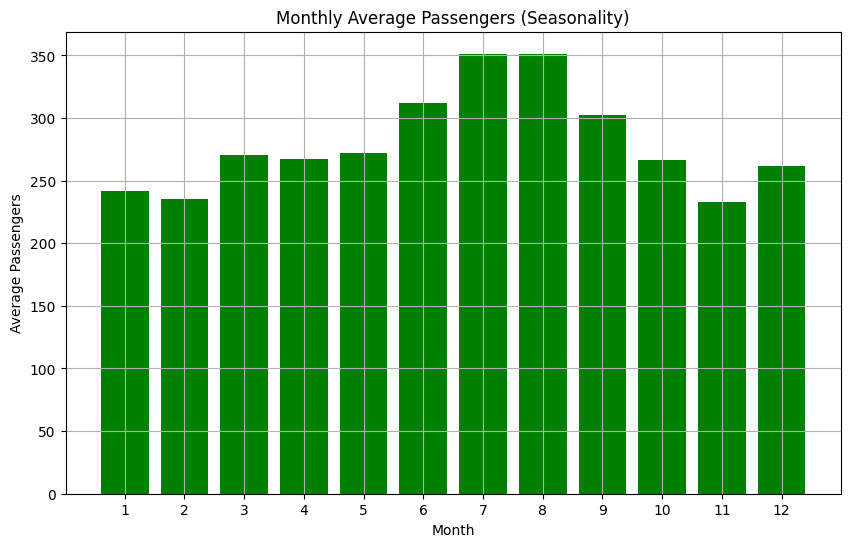

In [0]:
# Visualizing Seasonality: Monthly Average Passengers
import matplotlib.pyplot as plt

# Convert the seasonality DataFrame to Pandas for plotting
seasonality_pd = seasonality.toPandas()

# Plotting the monthly average
plt.figure(figsize=(10, 6))
plt.bar(seasonality_pd['Month'], seasonality_pd['Avg_Passengers'], color='green')
plt.title('Monthly Average Passengers (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Passengers')
plt.xticks(seasonality_pd['Month'])
plt.grid(True)
plt.show()


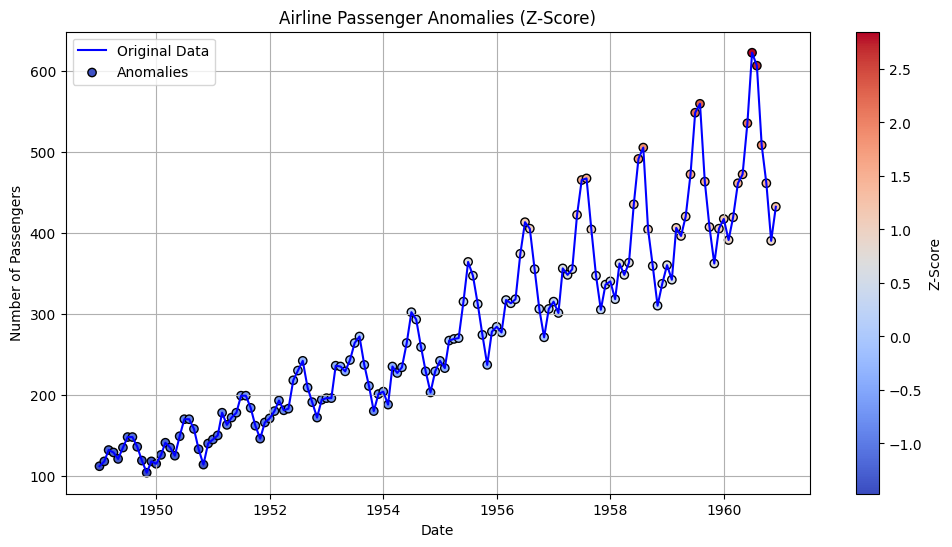

In [0]:
# Visualizing Anomalies using Z-Score
import matplotlib.pyplot as plt

# Convert the DataFrame with anomalies to Pandas
df_anomalies = df_with_anomalies.toPandas()

# Plotting the anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_anomalies['Date'], df_anomalies['#Passengers'], label='Original Data', color='blue')
plt.scatter(df_anomalies['Date'], df_anomalies['#Passengers'], c=df_anomalies['Z_Score'], cmap='coolwarm', label='Anomalies', edgecolors='black')
plt.title('Airline Passenger Anomalies (Z-Score)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.colorbar(label='Z-Score')
plt.legend()
plt.grid(True)
plt.show()
